#### This is a noteboook to test image similarity compare


In [56]:
import os
import cv2
import hashlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, applications
%matplotlib inline

os.environ['CPP_TF_MIN_LOG_LEVEL'] = '2'

print(tf.__version__)

2.7.0


In [57]:
# loading pre-trained ImageNet model with out top layer

# loading inception V3
inceptionV3 = applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(None, None, 3),
    pooling='avg'
)

# inceptionV3.summary()

In [58]:
# loading mobilenet V3
mobileNetV3 = applications.MobileNetV3Small(
    input_shape=None,
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=False
)

# mobileNetV3.summary()

In [59]:
# loading DenseNet121
denseNet121 = applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='avg'
)

# denseNet121.summary()

In [60]:
def concat_and_display_2_images(image_path_1, image_path_2, shape=(224, 224), interpolation=cv2.INTER_AREA):
    """ concat 2 image horizontally and display it in the window
    """
    # load image
    img_1 = cv2.imread(image_path_1)
    img_2 = cv2.imread(image_path_2)
    # resize image
    img_1 = cv2.resize(img_1, shape, interpolation=interpolation)
    img_2 = cv2.resize(img_2, shape, interpolation=interpolation)
    # concat 2 images 
    concat_img = np.concatenate((img_1, img_2), axis=1)
    # display 2 images
    cv2.imshow('concat image', concat_img)
    cv2.waitKey(0)
    #closing all open windows 
    cv2.destroyAllWindows()
    

def display_image_in_chart(files):
    _, axes = plt.subplots(3, 2, figsize=(15, 15))
    file_index = 0
    for row in range(0, 3):
        for col in range(0, 2):
            orig = cv2.imread(files[file_index])
            cv_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
            axes[row][col].imshow(cv_rgb)
            file_index += 1
    plt.show()

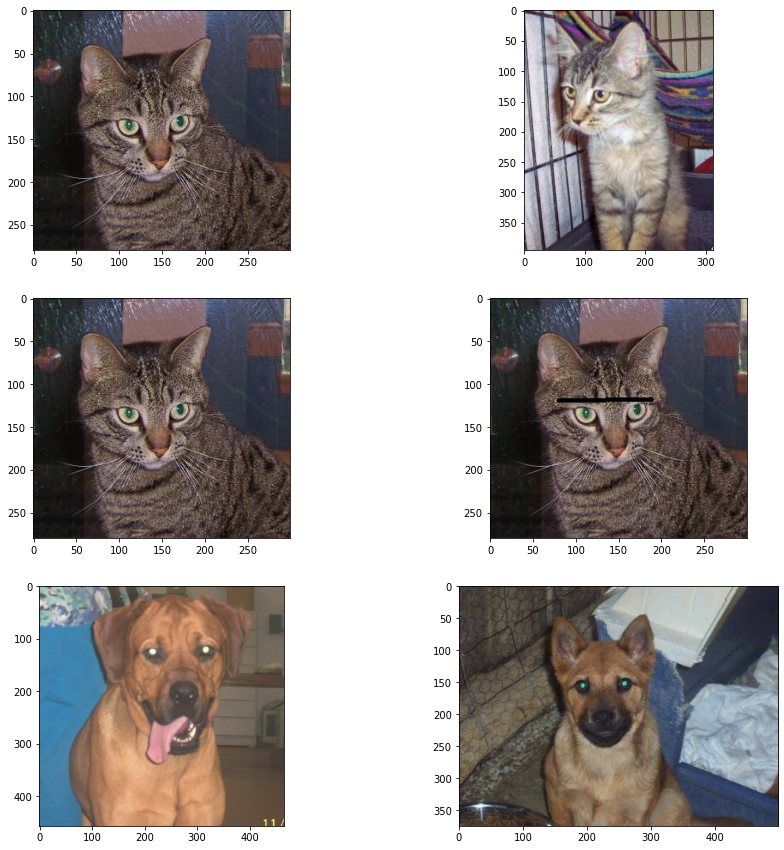

In [61]:
# display 2 cats image
cat_1, cat_2 = 'cat.1.jpg', 'cat.2.jpg'
cat_1, cat_1_modified = 'cat.1.jpg', 'cat.1.modified.jpg'
dog_1, dog_2 = 'dog.30.jpg', 'dog.32.jpg'

# images paths
image_files = [cat_1, cat_2, cat_1, cat_1_modified, dog_1, dog_2]

# call display function
display_image_in_chart(image_files)

In [62]:
def image_model(pre_trained_model):
    """ function to create a customized model based on pre-trained model
    """
    i = layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = applications.mobilenet.preprocess_input(x)
    x = pre_trained_model(x)
    model = Model(inputs=[i], outputs=[x])
    return model

def calc_image_vector(image_file_path, customized_model):
    """ function calc image vector
    """
    image = tf.image.decode_png(tf.io.read_file(image_file_path))
    image = tf.expand_dims(image, axis=0)
    result = customized_model(image)
    return result

def consine_similarity(v1, v2):
    """ function to calc consine similarity between 2 vectors
    """
    return tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(v1), tf.nn.l2_normalize(v2)))


def avg_similarity_score(key1, key2):
    score = 0
    for i in range(len(customized_models)):
        score += consine_similarity(image_obj[key1][i], image_obj[key2][i])
    return score/3

In [63]:
# create customized models
customized_inceptionV3 = image_model(inceptionV3)
customized_mobileNetV3 = image_model(mobileNetV3)
customized_denseNet121 = image_model(denseNet121)

customized_models = [customized_inceptionV3, customized_mobileNetV3, customized_denseNet121]

In [64]:
# image paths
image_obj = {
    'cat_1': cat_1, 
    'cat_2': cat_2, 
    'cat_1_m': cat_1_modified, 
    'dog_1': dog_1, 
    'dog_2': dog_2
}

# loop all the images to calc image vector
for k, v in image_obj.copy().items():
    image_vectors = []
    # loop models to calc vectors
    for m in customized_models:
        image_vectors.append(calc_image_vector(v, m))
    # put vector into image object
    image_obj[f'{k}_vector'] = image_vectors

image_obj

{'cat_1': 'cat.1.jpg',
 'cat_2': 'cat.2.jpg',
 'cat_1_m': 'cat.1.modified.jpg',
 'dog_1': 'dog.30.jpg',
 'dog_2': 'dog.32.jpg',
 'cat_1_vector': [<tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
  array([[0.05594236, 0.07179569, 0.0860808 , ..., 0.2312039 , 0.9832562 ,
          0.10751756]], dtype=float32)>,
  <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
  array([[-0.10819711, -0.37363258,  0.10027485, ...,  0.45161846,
          -0.15082766, -0.37348405]], dtype=float32)>,
  <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
  array([[7.6878344e-04, 3.6588456e-03, 5.7209488e-03, ..., 9.4920242e-01,
          2.7996907e-01, 1.1587524e+00]], dtype=float32)>],
 'cat_2_vector': [<tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
  array([[0.1704713 , 0.10460863, 0.17450279, ..., 0.30398005, 0.7217328 ,
          0.4582265 ]], dtype=float32)>,
  <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
  array([[-0.27789673, -0.28216812,  0.33116654, ...,  0.91636   ,
          -0.356940

In [65]:
compare_groups = [
    ['cat_1_vector', 'cat_2_vector'],
    ['dog_1_vector', 'dog_2_vector'],
    ['cat_1_vector', 'dog_1_vector'],
    ['cat_1_vector', 'dog_2_vector'],
    ['cat_2_vector', 'dog_1_vector'],
    ['cat_2_vector', 'dog_2_vector'],
    ['cat_1_vector', 'cat_1_m_vector']
]

avg_similarity_scores = []

# compare between each group
for group in compare_groups:
    group_1, group_2 = group[0], group[1]
    avg_similarity_scores.append(avg_similarity_score(group_1, group_2))

avg_similarity_scores

[<tf.Tensor: shape=(), dtype=float32, numpy=0.69653964>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.55747104>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.41787496>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4069935>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4173278>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.47298482>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.96726817>]

In [66]:
avg_similarity_scores[0].numpy()

0.69653964

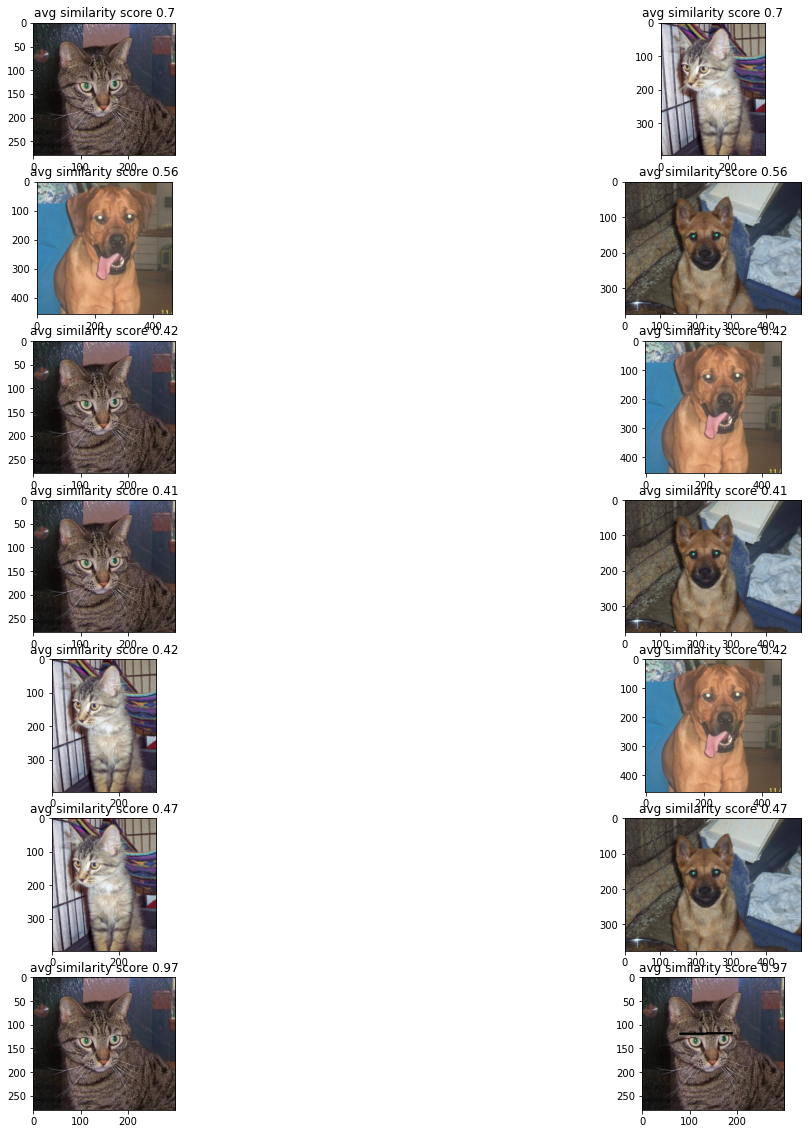

In [67]:
files = [
    cat_1, cat_2,
    dog_1, dog_2,
    cat_1, dog_1,
    cat_1, dog_2,
    cat_2, dog_1,
    cat_2, dog_2,
    cat_1, cat_1_modified
]

# display all the results
_, axes = plt.subplots(7, 2, figsize=(20, 20))
index = 0
for row in range(0, 7):
    avg_score = np.round(avg_similarity_scores[row].numpy(), 2)
    for col in range(0, 2):
        orig = cv2.imread(files[index])
        cv_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        axes[row][col].imshow(cv_rgb)
        axes[row][col].title.set_text(f'avg similarity score {str(avg_score)}')
        index += 1
plt.show()

In [68]:
def md5(fname):
    hash_md5 = hashlib.sha256()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [69]:
md5Sum = md5('cat.1.jpg')
md5Sum

'89b73bf41eb677cbbe5542e4be30aef330e2164a08a4d920f2bbe82be495dc99'

In [70]:
md5SumModified = md5('cat.1.modified.jpg')
md5SumModified

'd0fab4919a970747f3950d546c5f8f49391f81a3c2955223e085cbdf1da90167'